In [2]:
import os
import re
import operator

#Tables and matrices
import numpy as np
import pandas as pd
import sympy as sym

#Stats
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate
from scipy.stats.mstats import mquantiles
import statistics 

#Probabilistic programs
#!pip install pymc==5.0.2
#!pip install pytensor
import pymc as pm
import pytensor.tensor as pt
#import aesara.tensor as at
print('Running on PyMC v{}'.format(pm.__version__))


#Graphs
import seaborn as sns
import plotly.graph_objects as go
import altair as alt
#from altair_saver import save #ademas instalar en terminal: brew cask install chromedriver
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
#from graphviz import Source, Digraph
#import dot2tex as d2t
#from latex import build_pdf
from mpl_toolkits.mplot3d import axes3d
import arviz as az

Running on PyMC v5.1.1


# Decision-making (intertemporal discounting)

Santiago Alonso-Díaz, PhD <br>
Universidad Javeriana

<center><img src="img/10_CB/Cars_in_time.png" width = "600" height = '600'></center>

[Marshmellow Study](https://www.youtube.com/watch?v=JsQMdECFnUQ)

Basic idea behind all theories of intertemporal discounting:

Goods and services lose value in time i.e. the future is discounted

In general, the theory assumes that $x$ is preferred over $y$ in a time period $T$ if for a discount factor $\delta \in (0,1]$

$$\sum_{t \in T} \delta^tu(x_t)  \ge \sum_{t \in T} \delta^tu(y_t) $$




Let's see an example of a discounting function. We invest USD 10000, with an interest rate of 5%, for n periods (e.g. years). H

**Period 1**

$vf_1 = 10000 + 10000*0.05$    

$vf_1 = 10000(1+0.05)$

$vf_1 = 10000(1+0.05)^1$

**Period 2** 
   
$vf_2 = 10000(1+0.05)^1 + 10000(1+0.05)^1*0.05$

$vf_2 = 10000(1+0.05)^1(1+0.05)$

$vf_2 = 10000(1+0.05)^2$

**Period 3**

$vf_3 = 10000(1+0.05)^2 + 10000(1+0.05)^2*0.05$

$vf_3 = 10000(1+0.05)^2(1+0.05)$

$vf_3 = 10000(1+0.05)^3$


**Period n**

$vf_n = 10000(1+0.05)^n$




$$vf = vp(1+i)^n$$

$$vp = \frac{vf}{(1+i)^n}$$

Future values ($vf$) get discounted as a function of periods $n$ and interest rate $i$

People should prefer today $x$ over $y$ if $vp(x)>vp(y)$

The discount factor that multiplies $vf$ can change. These two are popular (k discount, D delay)

Exponential: $e^{-kD}$

Hyperbolic: $(1+kD)^{-1}$

Exponential: Is intertemporal consistent (derivative is linear on the delay) e.g. proportionally,. 0 vs 10 days is the same as 100 vs 110 days

Hyperbolic: tends to provides better fits to human data; it is intertemporal inconsistent (derivative is nonlinear on the delay value) and it is more impatient (faster discounts)

In [3]:
x = sym.Symbol('x')
sym.diff(sym.exp(-x), x) #derivative

-exp(-x)

In [4]:
sym.diff((1+x)**(-1), x)

-1/(x + 1)**2

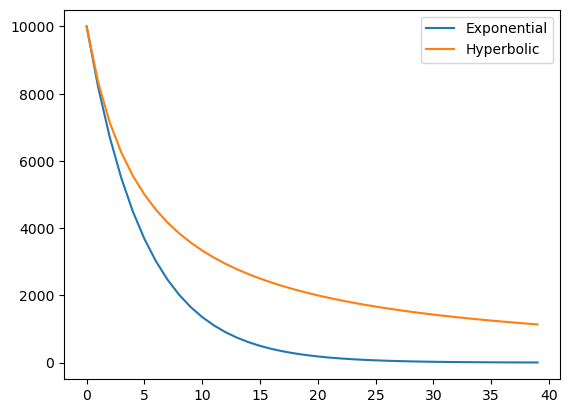

In [5]:
VF = 10000
k =0.2
D = np.arange(0,40)
plt.plot(D, VF*np.exp(-k*D), label = 'Exponential')
plt.plot(D, VF*(1+k*D)**(-1), label = 'Hyperbolic')
plt.legend();

In [6]:
#Example of preference reversal
VF1 = 10000
VF2 = 15000
Interval = 20 #e.g. in months

D1 = 0 #delays e.g. in months
D2 = D1 + Interval
exp_discount_A = (VF1*np.exp(-k*D1)) / (VF2*np.exp(-k*D2)) 
hyp_discount_A = (VF1*(1+k*D1)**(-1)) / (VF2*(1+k*D2)**(-1))

D1 = 60
D2 = D1 + Interval
exp_discount_B = (VF1*np.exp(-k*D1)) / (VF2*np.exp(-k*D2)) 
hyp_discount_B = (VF1*(1+k*D1)**(-1)) / (VF2*(1+k*D2)**(-1))

[exp_discount_A, exp_discount_B, hyp_discount_A, hyp_discount_B] #>1 VF1 preferred; <1 VF2 preferred; Note that exponential discount is constant



[36.39876668876283, 36.39876668876283, 3.3333333333333335, 0.8717948717948718]

# Empirical intertemporal behavior

## Preference reversals (Green, Fristoe, & Myerson, 1994)

Procedure (n = 24):
    
<center><img src="img/10_CB/Pref_Reversal.png" width = "600" height = '600'></center>

Reversal: preference for larger and later reward changes with weeks to smaller reward

Consistent subjects should look like an horizontal line.


<center><img src="img/10_CB/Pref_Reversal_2.png" width = "400" height = '400'></center>


Another way of seeing the reversal. Indifference points i.e. combination of delays where subjects chose later or sooner with 50% probability.

Consistent subjects should look like a straight line, not with negative curvature (a simple polynomial was a worst fit).

<center><img src="img/10_CB/Pref_Reversal_3.png" width = "400" height = '400'></center>

The reversal is present in individual subjects (i.e. not just an averaging effect)
<center><img src="img/10_CB/Pref_Reversal_4.png" width = "600" height = '600'></center>

# Magnitude effects
<center><img src="img/10_CB/Magnitude_Effect.png" width = "400" height = '400'></center>

Hypothesis 1: there is only one discount factor thus magnitudes should not matter e.g. discounting a monetary unit in 10 vs 100 is the same as 100 vs 1000

Hypothesis 2: people are more patient with larger magnitudes e.g. discounting a monetary unit in 10 vs 100 is different than 100 vs 1000

Procedure: pick between two options that differ in amount and delay between them
<center><img src="img/10_CB/Magnitude_Effect_2.png" width = "600" height = '600'></center>

Another way of visualizing the results. The (hyperbolic) discount factor decreases with the magnitude i.e. more patience

<center><img src="img/10_CB/Magnitude_Effect_3.png" width = "400" height = '400'></center>

# Endogenous influences

Discounting is not only about numerical info. Endogenous processes influence discounting

<center><img src="img/10_CB/Magnitude_Effect_4.png" width = "700" height = '700'></center>

Discounting is not only about numerical info. Endogenous processes influence discounting

<center><img src="img/10_CB/Brain_discount.png" width = "700" height = '700'></center>

The brain seems to process sooner and later rewards at different locations

<center><img src="img/10_CB/Brain_discount_2.png" width = "700" height = '700'></center>

# General behavioral patterns around the world

From Mamo et al (2022), The globalizability of temporal discounting, Nature Human Behaviour:

1) **Absolute magnitude**: Increased preference for delayed gains when values become substantially larger.

2) **Gain–loss asymmetry**: Gains are discounted more than losses.

3) **Delay–speedup asymmetry**: Accepting an immediate, smaller gain if the delay is framed as added value, but preferring the larger, later amount if an immediate gain is framed as a reduction (for example, prefer a gain of \\$500 rather than wait 12 months for an additional \\$50 and prefer to wait for 12 months to receive \\$550 rather than to pay \\$50 and receive the gain now).

4) **Present bias**: Lower discounting over a given time interval when the start of the interval is shifed to the future.

5) **Subadditivity**: Higher discounting for two separate shorter periods than when considered together. For instance: 0–12, 12–24 and 0–24 months. discounting is higher for the two 12-month intervals than for the 24-month interval.

https://www.nature.com/articles/s41562-022-01392-w


<center><img src="img/10_CB/Mamo_et_al_globalization_of_temporal_discounting.svg" width = "700" height = '700'></center>



Countries as a whole are very similar (i.e. not a single country is extreme in a pattern). However, the behavioral patterns depend on economic situation of the countries, in particular inequality (Gini) and inflation i.e. it is a rational response:

<center><img src="img/10_CB/Mamo_et_al_globalization_of_temporal_discounting_2.svg" width = "700" height = '700'></center>

# Estimation of parameters

Do the intertemporal task in Pavlovia (santiago):

Money today vs Money in the future



## Non-hierarchical estimation (i.e. unpooled estimate i.e. no dependencies between $k_s$)

### Hyperbolic discounting
<br><br>

<center><img src="img/10_CB/intertemp_diagram.svg" width = "800" height = '800'></center>


In [7]:
#Load and data setup
data_folder = 'data/10_CB'
ff = os.listdir(data_folder)
unreadable_files = []
onlyfiles = []
counter_unreadable = 0
for f in ff:
    #print(f)
    fff = data_folder + "/" + f
    good_file = 0
    unreadable = 0
    if counter_unreadable < len(unreadable_files): 
        if f == unreadable_files[counter_unreadable]:
            counter_unreadable = counter_unreadable+1
            unreadable = 1
    
    if os.stat(fff).st_size > 500 and unreadable==0: #in bytes    
        data_subj = pd.read_csv(fff)
        nrows = data_subj.shape[0]
        if nrows>50:
            good_file = 1
    x = re.search(".csv",f)
    j = re.search('.~lock.',f) #linux or pavlovia seem to create this name files
    if x and operator.not_(j) and good_file==1:
        onlyfiles.append(f)

for idx, f in enumerate(onlyfiles):
    data = pd.read_csv('data/10_CB/'+f)
    data = data.loc[~data['ss_Amt'].isna(),:]
    if idx == 0:
        #DATA=data.loc[:,['participant', 'respT.corr','respT.rt', #corr: 0 sooner; 1 later
        #                 'ss_Amt','ss_Delay','ll_Amt','ll_Delay']] #ss: smaller sooner; ll: larger later; Amt: amount
        
        choice = np.array(data.loc[:,'respT.corr'], ndmin=2).T #0 sooner; 1 later
        ss_Amt = np.array(data.loc[:,'ss_Amt']/1000, ndmin=2).T #sooner smaller amount (/1000 to take 3 zeros away from COPs)
        ss_Delay = np.array(data.loc[:,'ss_Delay'], ndmin=2).T 
        ll_Amt = np.array(data.loc[:,'ll_Amt']/1000, ndmin=2).T #later larger amount (/1000 to take 3 zeros away from COPs)
        ll_Delay = np.array(data.loc[:,'ll_Delay'], ndmin=2).T
    else:
        #DATA = pd.concat([DATA, data.loc[:,['participant', 'respT.corr','respT.rt', 
        #                                    'ss_Amt','ss_Delay','ll_Amt','ll_Delay']]])
        choice = np.concatenate([choice, np.array(data.loc[:,'respT.corr'], ndmin=2).T], axis=1)  #
        ss_Amt = np.concatenate([ss_Amt, np.array(data.loc[:,'ss_Amt']/1000, ndmin=2).T], axis=1)  #sooner smaller amount 
        ss_Delay = np.concatenate([ss_Delay, np.array(data.loc[:,'ss_Delay'], ndmin=2).T], axis=1) 
        ll_Amt = np.concatenate([ll_Amt, np.array(data.loc[:,'ll_Amt']/1000, ndmin=2).T], axis=1)  #later larger amount 
        ll_Delay = np.concatenate([ll_Delay, np.array(data.loc[:,'ll_Delay'], ndmin=2).T], axis=1) 
    
n = choice.shape[1] #len(onlyfiles)   
#DATA = DATA.reset_index(drop=True)
#n = len(DATA['participant'].unique())


In [8]:
[onlyfiles, n]

[['impaciente_tareaTDv3_2022-07-08_16h48.54.684.csv',
  'paciente_tareaTDv3_2022-07-08_10h29.12.042.csv',
  'random_tareaTDv3_2022-07-09_06h46.43.116.csv'],
 3]

In [9]:
with pm.Model() as unpooled:
    #Priors
    ks = pm.Uniform("k_s", lower=0, upper=10, shape = n)
    betas = pm.Uniform("beta_s", lower=0, upper=10, shape = n)
    
    
    #Likelihood
    v_ss = pm.Deterministic('v_ss', ss_Amt/(1+ss_Delay*ks)) #smaller sooner value
    v_ll = pm.Deterministic('v_ll', ll_Amt/(1+ll_Delay*ks)) #later larger value
    
    p_later = pm.Deterministic('p_later', 1/(1+pt.exp((v_ll-v_ss)*(-betas))))
    
    choice_later = pm.Bernoulli("choice_later", p=p_later, observed=choice)

    trace = pm.sample(4000, tune=2000, target_accept=0.9, cores=4, chains = 4)
    PPC =  pm.sample_posterior_predictive(trace, var_names = ['choice_later','v_ss', 'v_ll', 'p_later'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k_s, beta_s]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 30 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int32 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int32 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int32 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int32 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [choice_later]


In [10]:
resu = az.summary(trace)
(resu['r_hat']>1.05).mean()

C:\Users\Santiago Diaz\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


0.0

In [214]:
#az.plot_trace(trace, compact=False);
#plt.tight_layout()

In [12]:
resu

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s[0],8.557,0.900,7.154,10.000,0.010,0.008,6240.0,4452.0,1.0
k_s[1],0.001,0.001,0.000,0.002,0.000,0.000,7237.0,7439.0,1.0
k_s[2],4.583,2.956,0.067,9.337,0.028,0.021,10663.0,9348.0,1.0
beta_s[0],5.497,2.634,1.357,9.898,0.028,0.022,8078.0,6291.0,1.0
beta_s[1],2.969,2.527,0.203,8.200,0.029,0.021,9025.0,7895.0,1.0
...,...,...,...,...,...,...,...,...,...
"p_later[88, 1]",1.000,0.000,1.000,1.000,0.000,0.000,12868.0,15032.0,1.0
"p_later[88, 2]",0.432,0.052,0.338,0.500,0.001,0.000,6131.0,4367.0,1.0
"p_later[89, 0]",0.000,0.000,0.000,0.000,0.000,0.000,8086.0,6310.0,1.0
"p_later[89, 1]",0.998,0.011,0.990,1.000,0.000,0.000,10219.0,15027.0,1.0


In [13]:
subj = 0
resu.loc['beta_s[' + str(subj) + ']',:]['mean']

5.497

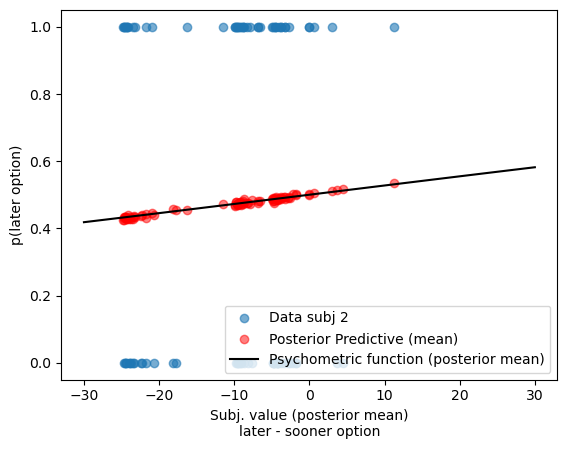

In [14]:
subj = 2
#ee_pp = resu.loc['e_p[' + str(subj) + ']',:]['mean']
#ss_pp = resu.loc['s_p[' + str(subj) + ']',:]['mean']
bbetas = resu.loc['beta_s[' + str(subj) + ']',:]['mean']
choice_subj = choice[:, subj]
ss_Amt_subj = ss_Amt[:, subj]
ll_Amt_subj = ll_Amt[:, subj]

temp_model = np.array(PPC.posterior_predictive['choice_later'])
temp_model = temp_model.reshape((temp_model.shape[0]*temp_model.shape[1],temp_model.shape[2],temp_model.shape[3]))
choice_model = temp_model[:,:,subj]

temp_model = np.array(PPC.posterior_predictive['v_ss'])
temp_model = temp_model.reshape((temp_model.shape[0]*temp_model.shape[1],temp_model.shape[2],temp_model.shape[3]))
v_ss_Amt_model = temp_model[:,:,subj]

temp_model = np.array(PPC.posterior_predictive['v_ll'])
temp_model = temp_model.reshape((temp_model.shape[0]*temp_model.shape[1],temp_model.shape[2],temp_model.shape[3]))
v_ll_Amt_model = temp_model[:,:,subj]

#plt.scatter(ll_Amt_subj-ss_Amt_subj, choice_subj, label = 'Data subj ' + str(subj))
#plt.scatter(ll_Amt_subj-ss_Amt_subj, choice_model.mean(axis=0), color='red', alpha = 0.4, label = 'Posterior Predictive (mean)')
plt.scatter(v_ll_Amt_model.mean(axis=0)-v_ss_Amt_model.mean(axis=0), choice_subj, label = 'Data subj ' + str(subj), alpha = 0.6)
plt.scatter(v_ll_Amt_model.mean(axis=0)-v_ss_Amt_model.mean(axis=0), choice_model.mean(axis=0), color='red', alpha = 0.5, label = 'Posterior Predictive (mean)')
plt.plot(np.linspace(-30,30,100), 1/(1+np.exp(np.linspace(-30,30,100)*(-bbetas))),
         color = 'black', label = 'Psychometric function (posterior mean)')
plt.xlabel('Subj. value (posterior mean)\nlater - sooner option')
plt.ylabel('p(later option)')
plt.legend();

## Hierarchical estimation

<center><img src="img/10_CB/Bayes_estimation_discount.png" width = "700" height = '700'></center>


This is a more complex model: hierarchical and with magnitude effects.

Hierarchical means that individuals share a structure (e.g. all come from the same culture/city/school), so their discount parameters come from a common source (but still individual).

Magnitude effects mean that the discount factor is a function of the reward. In an hyperbolic discount,  

$$Subj. Value = \frac{Reward}{1+f(reward)Delay}$$

Vincent proposes:

$$f(reward) = exp^{m\times log(reward)+c}$$

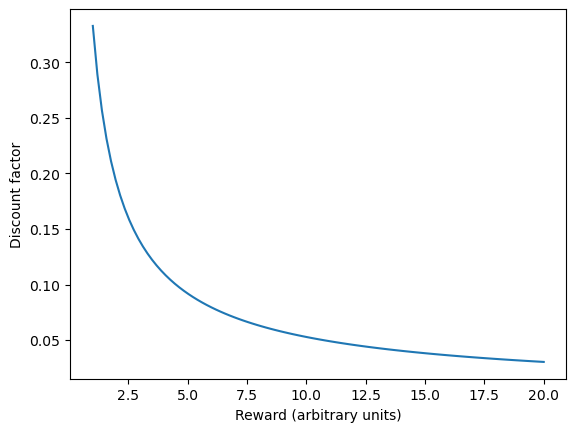

In [15]:
reward = np.linspace(1, 20, 100)
mmm = -0.8
ccc =  -1.1
plt.plot(reward, np.exp(mmm*np.log(reward)+ccc));
plt.xlabel('Reward (arbitrary units)')
plt.ylabel('Discount factor');

Choice is stochastic. Remember that the previous model used a sigmoid, specifically a logistic. Vincent also uses a sigmoid i.e. a standard normal CDF (with some additional parameters). 

$$ p(later \; option) = \epsilon + (1-2\epsilon)\phi\left(\frac{Subj.Value_{later}-Subj.Value_{sooner}}{\alpha}\right)$$ 

$\epsilon$ is error rate <br>
$\alpha$ modulates discriminability between options

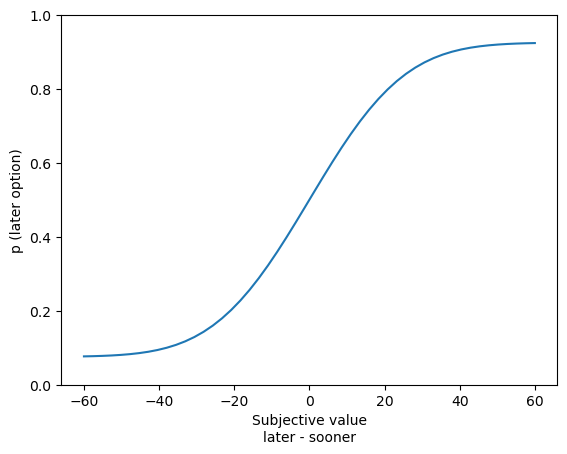

In [16]:
epsilon = 0.075 #base error rate and max performance
alpha = 20 #ability to discriminate between subj. values
Diff_subj_value = np.linspace(-60,60)
plt.plot(Diff_subj_value,
        epsilon + (1-2*epsilon)*st.norm.cdf(Diff_subj_value/alpha))
plt.ylim((0,1))
plt.xlabel('Subjective value\nlater - sooner')
plt.ylabel('p (later option)');

$\epsilon$ is a base error rate e.g. due to inattention
<center><img src="img/10_CB/Vincent2016-1.svg" width = "500" height = '500'></center>


<center><img src="img/10_CB/intertemp_diagram_hierarchical.svg" width = "800" height = '800'></center>
Note: $\omega$ and $\kappa$ modulate the error rate but Vincent does not justify those priors in his paper

In [17]:
#Load and data setup
data_folder = 'data/10_CB/Benjamin_Vincent/kirby'
ff = os.listdir(data_folder)
unreadable_files = []
onlyfiles = []
counter_unreadable = 0
for f in ff:
    #print(f)
    fff = data_folder + "/" + f
    good_file = 0
    unreadable = 0
    if counter_unreadable < len(unreadable_files): 
        if f == unreadable_files[counter_unreadable]:
            counter_unreadable = counter_unreadable+1
            unreadable = 1
    
    if os.stat(fff).st_size > 250 and unreadable==0: #in bytes    
        data_subj = pd.read_csv(fff)
        nrows = data_subj.shape[0]
        if nrows>5:
            good_file = 1
    x = re.search(".txt",f)
    j = re.search('.~lock.',f) #linux or pavlovia seem to create this name files
    if x and operator.not_(j) and good_file==1:
        onlyfiles.append(f)
#Column names mean:

#A reward of option A
#DA delay of option A, in days
#PA probability of achieving the reward (not in Kirby's data)
#B reward of option B
#DB delay of option B, in days
#PB probability of achieving the reward (not in Kirby's data)
#R is the participant response.
#The preferred way of coding participant responses R is by the unambiguous label A or B. 
#In Kirby's data coding scheme was R = 1 for chose delayed and R = 0 for chose immediate.


for idx, f in enumerate(onlyfiles):
    data = pd.read_table('data/10_CB/Benjamin_Vincent/kirby/'+f)
    #data = data.loc[~data['ss_Amt'].isna(),:]
    if idx == 0:
        choice = np.array(data.loc[:,'R'], ndmin=2).T #0 sooner; 1 later
        ss_Amt = np.array(data.loc[:,'A'], ndmin=2).T #sooner smaller amount 
        ss_Delay = np.array(data.loc[:,'DA'], ndmin=2).T 
        ll_Amt = np.array(data.loc[:,'B'], ndmin=2).T #later larger amount 
        ll_Delay = np.array(data.loc[:,'DB'], ndmin=2).T
    else:
        choice = np.concatenate([choice, np.array(data.loc[:,'R'], ndmin=2).T], axis=1)  #
        ss_Amt = np.concatenate([ss_Amt, np.array(data.loc[:,'A'], ndmin=2).T], axis=1)  #sooner smaller amount 
        ss_Delay = np.concatenate([ss_Delay, np.array(data.loc[:,'DA'], ndmin=2).T], axis=1) 
        ll_Amt = np.concatenate([ll_Amt, np.array(data.loc[:,'B'], ndmin=2).T], axis=1)  #later larger amount 
        ll_Delay = np.concatenate([ll_Delay, np.array(data.loc[:,'DB'], ndmin=2).T], axis=1) 
    
n = choice.shape[1] #len(onlyfiles)   


In [43]:
#https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/dimensionality.html
with pm.Model() as hierarchical:
    #Priors Group Level
    #Benjamin Vincent implements an idea the the discount factor k is a function of the reward magnitude i.e
    # log(k) = m*log(reward) + c  ... this is a linear function in log scale for the reward
    # For choice probabilities, he uses a sigmoid i.e. a normal CDF with mu = f(reward differences) and sigma = free parameter 
    Mu_c = pm.Normal('Mu_c', mu = 0, sigma = 10000) #constant c
    Sigma_c = pm.Uniform('Sigma_c', lower = 0, upper = 10000)
    Mu_m = pm.Normal('Mu_m', mu = -2.43, sigma = 0.27) #slope m
    Sigma_m = pm.TruncatedNormal('Sigma_m', mu = 0.072, sigma = 0.25, lower = 0)
    #Mu_m = pm.Normal('Mu_m', mu = 0, sigma = 10) #slope m
    #Sigma_m = pm.TruncatedNormal('Sigma_m', mu = 0, sigma = 10, lower = 0)
    omega = pm.Beta('omega', alpha = 1.1, beta = 10.9)
    kappa = pm.Gamma('kappa', alpha = 0.01, beta = 0.01)
    Mu_acuity = pm.Uniform('Mu_acuity', lower = 0, upper = 1000) #choice acuity i.e. alpha (akin to temperature in a softmax)
    Sigma_acuity = pm.Uniform('Sigma_acuity', lower = 0, upper = 1000)
    
    #Priors Participant Level
    c_p = pm.Normal('c_p', mu = Mu_c, sigma = Sigma_c, shape = n) #constant c
    m_p = pm.Normal('m_p', mu = Mu_m, sigma = Sigma_m, shape = n) #slope m
    
    e_p = pm.Beta("e_p", 1, 1, shape = n) #choice-error
    #e_p = pm.Truncated('e_p', 
    #                   pm.Beta.dist(alpha = omega*(kappa-2) + 1, beta = (1-omega)*(kappa-2) + 1), 
    #                   #pm.Beta.dist(alpha = 1, beta = 1), 
    #                   lower = 0.0, upper = 0.5, shape = n) #choice-error
    s_p = pm.TruncatedNormal('s_p', mu = Mu_acuity, sigma = Sigma_acuity, lower = 0, shape = n) #choice acuity i.e. alpha
    
    #Likelihood
    k_ss = pt.exp(np.log(ss_Amt)*m_p+c_p)
    k_ll = pt.exp(np.log(ll_Amt)*m_p+c_p)
    
    v_ss = pm.Deterministic('v_ss', ss_Amt/(1+ss_Delay*k_ss)) #smaller sooner value
    v_ll = pm.Deterministic('v_ll', ll_Amt/(1+ll_Delay*k_ll)) #later larger value
    
    
    phi = pm.Normal('phi', mu=0, sigma=1)
    #p_later = e_p + (1-2*e_p) * at.exp(pm.logcdf(phi, (v_ll-v_ss)/s_p)) # 
    p_later =  pm.Deterministic('p_later', e_p + (1-2*e_p) * pt.exp(pm.logcdf(phi, (v_ll-v_ss)/s_p)))
    
    choice_later = pm.Bernoulli("choice_later", p = p_later, observed = choice)

    trace = pm.sample(4000, tune=1500, target_accept=0.95, cores=4, chains = 4) #, init = "adapt_diag")
    PPC =  pm.sample_posterior_predictive(trace, var_names = ['choice_later','v_ss', 'v_ll', 'p_later'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mu_c, Sigma_c, Mu_m, Sigma_m, omega, kappa, Mu_acuity, Sigma_acuity, c_p, m_p, e_p, s_p, phi]


Sampling 4 chains for 1_500 tune and 4_000 draw iterations (6_000 + 16_000 draws total) took 1536 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 438 divergences after tuning. Increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int32 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int32 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int32 2 reached the maximum tree 

In [36]:
resu=az.summary(trace)
(resu['r_hat']>1.05).mean()

C:\Users\Santiago Diaz\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


0.0

In [37]:
resu

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Mu_c,1.469,0.641,0.304,2.717,0.024,0.017,734.0,1136.0,1.01
Mu_m,-1.505,0.158,-1.806,-1.214,0.006,0.004,748.0,1200.0,1.01
c_p[0],1.490,0.675,0.185,2.732,0.024,0.017,784.0,1264.0,1.01
c_p[1],1.621,0.690,0.286,2.900,0.024,0.017,822.0,1416.0,1.01
c_p[2],1.622,0.687,0.317,2.911,0.024,0.017,827.0,1384.0,1.01
...,...,...,...,...,...,...,...,...,...
"p_later[26, 10]",0.077,0.107,0.000,0.273,0.001,0.001,4431.0,7235.0,1.00
"p_later[26, 11]",0.943,0.049,0.854,1.000,0.000,0.000,8319.0,6000.0,1.00
"p_later[26, 12]",0.955,0.042,0.878,1.000,0.000,0.000,7984.0,6176.0,1.00
"p_later[26, 13]",0.962,0.036,0.894,1.000,0.000,0.000,9789.0,5834.0,1.00


In [38]:
[resu.loc['Mu_m',:], resu.loc['Mu_c',:], resu.loc['Mu_acuity',:], resu.loc['e_p[8]',:]['mean']]

[mean           -1.505
 sd              0.158
 hdi_3%         -1.806
 hdi_97%        -1.214
 mcse_mean       0.006
 mcse_sd         0.004
 ess_bulk      748.000
 ess_tail     1200.000
 r_hat           1.010
 Name: Mu_m, dtype: float64,
 mean            1.469
 sd              0.641
 hdi_3%          0.304
 hdi_97%         2.717
 mcse_mean       0.024
 mcse_sd         0.017
 ess_bulk      734.000
 ess_tail     1136.000
 r_hat           1.010
 Name: Mu_c, dtype: float64,
 mean            2.611
 sd              1.536
 hdi_3%          0.003
 hdi_97%         5.061
 mcse_mean       0.064
 mcse_sd         0.045
 ess_bulk      587.000
 ess_tail     1503.000
 r_hat           1.000
 Name: Mu_acuity, dtype: float64,
 0.037]

In [39]:
trace.posterior

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 4000, c_p_dim_0: 15, m_p_dim_0: 15,
                    e_p_dim_0: 15, s_p_dim_0: 15, v_ss_dim_0: 27,
                    v_ss_dim_1: 15, v_ll_dim_0: 27, v_ll_dim_1: 15,
                    p_later_dim_0: 27, p_later_dim_1: 15)
Coordinates:
  * chain          (chain) int32 0 1 2 3
  * draw           (draw) int32 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
  * c_p_dim_0      (c_p_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * m_p_dim_0      (m_p_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * e_p_dim_0      (e_p_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * s_p_dim_0      (s_p_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * v_ss_dim_0     (v_ss_dim_0) int32 0 1 2 3 4 5 6 7 ... 20 21 22 23 24 25 26
  * v_ss_dim_1     (v_ss_dim_1) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * v_ll_dim_0     (v_ll_dim_0) int32 0 1 2 3 4 5 6 7 ... 20 21 22 23 24 25 26
  * v_ll_dim_1     (v_ll_dim_1) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * p_later_dim_0  (p_later_dim_0) int32 0 1 2 3 4 5 6 ... 20 21 22 23 24 25 26
  * p_later_dim_1  (p_later_dim_1) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
Data variables: (12/16)
    Mu_c           (chain, draw) float64 1.731 1.895 1.874 ... 1.677 1.927 2.049
    Mu_m           (chain, draw) float64 -1.584 -1.608 -1.606 ... -1.634 -1.606
    c_p            (chain, draw, c_p_dim_0) float64 1.953 2.313 ... 1.991 2.226
    m_p            (chain, draw, m_p_dim_0) float64 -1.588 -1.597 ... -1.721
    phi            (chain, draw) float64 -0.4617 -0.8707 ... -1.388 0.4227
    Sigma_c        (chain, draw) float64 0.3795 0.1957 0.3194 ... 0.09438 0.1346
    ...             ...
    Sigma_acuity   (chain, draw) float64 2.363 1.697 2.728 ... 4.95 3.139 3.89
    e_p            (chain, draw, e_p_dim_0) float64 0.02182 0.02395 ... 0.05097
    s_p            (chain, draw, s_p_dim_0) float64 1.131 4.783 ... 1.529 5.162
    v_ss           (chain, draw, v_ss_dim_0, v_ss_dim_1) float64 80.0 ... 55.0
    v_ll           (chain, draw, v_ll_dim_0, v_ll_dim_1) float64 43.44 ... 56.16
    p_later        (chain, draw, p_later_dim_0, p_later_dim_1) float64 0.0218...
Attributes:
    created_at:                 2023-03-13T22:32:17.673347
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.1.1
    sampling_time:              1705.461072921753
    tuning_steps:               1500

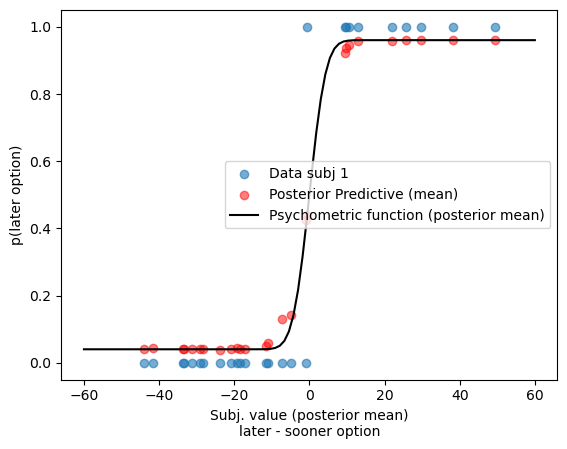

In [40]:
#choice
#ss_Amt
#ss_Delay 
#ll_Amt 
#ll_Delay

subj = 1
ee_pp = resu.loc['e_p[' + str(subj) + ']',:]['mean']
ss_pp = resu.loc['s_p[' + str(subj) + ']',:]['mean']
choice_subj = choice[:, subj]
ss_Amt_subj = ss_Amt[:, subj]
ll_Amt_subj = ll_Amt[:, subj]

temp_model = np.array(PPC.posterior_predictive['choice_later'])
temp_model = temp_model.reshape((temp_model.shape[0]*temp_model.shape[1],temp_model.shape[2],temp_model.shape[3]))
choice_model = temp_model[:,:,subj]

temp_model = np.array(PPC.posterior_predictive['v_ss'])
temp_model = temp_model.reshape((temp_model.shape[0]*temp_model.shape[1],temp_model.shape[2],temp_model.shape[3]))
v_ss_Amt_model = temp_model[:,:,subj]

temp_model = np.array(PPC.posterior_predictive['v_ll'])
temp_model = temp_model.reshape((temp_model.shape[0]*temp_model.shape[1],temp_model.shape[2],temp_model.shape[3]))
v_ll_Amt_model = temp_model[:,:,subj]

#plt.scatter(ll_Amt_subj-ss_Amt_subj, choice_subj, label = 'Data subj ' + str(subj))
#plt.scatter(ll_Amt_subj-ss_Amt_subj, choice_model.mean(axis=0), color='red', alpha = 0.4, label = 'Posterior Predictive (mean)')
plt.scatter(v_ll_Amt_model.mean(axis=0)-v_ss_Amt_model.mean(axis=0), choice_subj, label = 'Data subj ' + str(subj), alpha = 0.6)
plt.scatter(v_ll_Amt_model.mean(axis=0)-v_ss_Amt_model.mean(axis=0), choice_model.mean(axis=0), color='red', alpha = 0.5, label = 'Posterior Predictive (mean)')
plt.plot(np.linspace(-60,60,100), ee_pp + (1-2*ee_pp) * st.norm.cdf(np.linspace(-60,60,100) / ss_pp ),
         color = 'black', label = 'Psychometric function (posterior mean)')
plt.xlabel('Subj. value (posterior mean)\nlater - sooner option')
plt.ylabel('p(later option)')
plt.legend();